In [28]:
%tensorflow_version 2.x

In [29]:
import zipfile
f = zipfile.ZipFile("./drive/My Drive/train.zip")
f.extractall("./datasets")

In [30]:
import glob
catfn = glob.glob("datasets/*/cat.*")
dogfn = glob.glob("datasets/*/dog.*")
print("貓圖片共有:", len(catfn), "張")
print("狗圖片共有:", len(dogfn), "張")
catans = [0] * len(catfn)
dogans = [1] * len(dogfn)

貓圖片共有: 12500 張
狗圖片共有: 12500 張


In [31]:
import pandas as pd
datas = {
    "path":catfn + dogfn,
    "target": catans + dogans    
}
df = pd.DataFrame(datas)
df

,path,target
0,datasets/train/cat.3019.jpg,0
1,datasets/train/cat.1006.jpg,0
2,datasets/train/cat.8065.jpg,0
3,datasets/train/cat.4266.jpg,0
4,datasets/train/cat.5186.jpg,0
...,...,...
24995,datasets/train/dog.9963.jpg,1
24996,datasets/train/dog.7129.jpg,1
24997,datasets/train/dog.541.jpg,1
24998,datasets/train/dog.8467.jpg,1


#### load_img 在需要顯示圖片的時候才顯示, 減少計算量

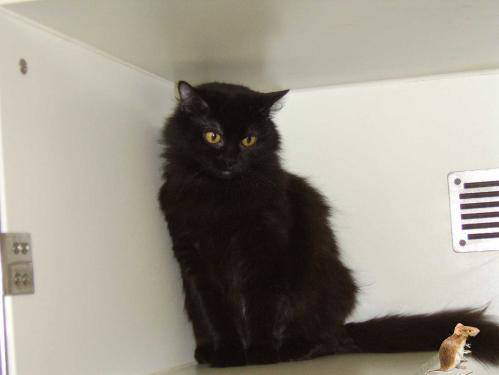

In [32]:
from tensorflow.keras.preprocessing.image import load_img
import random
import matplotlib.pyplot as plt
%matplotlib inline
p = random.randint(0, 24999)
image = load_img(df["path"][p])
image

In [33]:
# 拿 VGG16 
from tensorflow.keras.applications import  VGG16
cnn = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
cnn.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
for i in cnn.layers:
  i.trainable = False
x = BatchNormalization()(cnn.output)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [35]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [36]:
# 訓練之前把所有 list, series  轉成 np.array
from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(df["target"]),
                                                    test_size=0.1)

In [37]:
# np.random.randint 可以隨機拿出多數張圖
x, y = x_train, y_train
idx = np.random.randint(0, x.shape[0], size=20)
idx

array([ 9464, 21229, 16827, 19281,  7761,  9683, 18580, 12922, 14592,
       10175, 21376,  5351, 19112,  7164, 10503,  5549, 22423,  2209,
        7109,  8014])

In [38]:
# x_batch 為隨機一批 x的圖,
x_batch, y_batch = x[idx], y[idx]
y_batch # 約 20 張圖片的答案

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1])

In [39]:
# 用 keras 裡面給的預處理來處理圖片, 每一個模型都有自己的處理方式內建於 keras 內
from tensorflow.keras.applications.vgg16 import preprocess_input
# dataflow 回傳 (原圖batch, 處理後batch, 答案batch)
def dataflow(x, y, batch=20):
  idx = np.random.randint(0, x.shape[0], size=20)
  x_batch, y_batch = x[idx], y[idx]
  x_ori, x_pre = [], [] # 有些原圖還需要用, 先儲存
  for fp in x_batch:
    img = load_img(fp, target_size=(224, 224))
    img_np = np.array(img)
    x_ori.append(img_np) # 原本圖片儲存一份
    img_pre = preprocess_input(img_np)
    x_pre.append(img_pre)
  x_ori, x_pre = np.array(x_ori), np.array(x_pre)
  return (x_ori, x_pre, y_batch)
#print("原圖的情況:", x_ori.shape) # 20 張圖, 224, 224, 3
#print("預處理後的圖情況:", x_pre.shape)

#### 圖檔太大時使用批次訓練, 用 train_on_batch, 返回 ["loss", "accuracy"]
#### test_on_batch, 返回 ["val_loss", "val_accuracy"]
#### 參考: https://keras.io/zh/models/model/

In [40]:
# 開始訓練, 原圖沒用到不取名字用 _ 代替
for i in range(50):
  print("-"*10 + "目前訓練次數為:", i, "-" *10)
  _, x, y =  dataflow(x_train, y_train, batch=40)
  result = model.train_on_batch(x, y)
  print(["train"], result)
  # 驗證模型
  _, x , y = dataflow(x_test, y_test)
  result = model.test_on_batch(x, y)
  print(["validate"], result)

----------目前訓練次數為: 0 ----------
['train'] [1.6769065856933594, 0.3499999940395355]
['validate'] [9.078989028930664, 0.6000000238418579]
----------目前訓練次數為: 1 ----------
['train'] [0.8107908964157104, 0.6499999761581421]
['validate'] [4.933660507202148, 0.75]
----------目前訓練次數為: 2 ----------
['train'] [0.22829480469226837, 0.8999999761581421]
['validate'] [0.0029309592209756374, 1.0]
----------目前訓練次數為: 3 ----------
['train'] [0.22319626808166504, 0.8999999761581421]
['validate'] [1.945553183555603, 0.8500000238418579]
----------目前訓練次數為: 4 ----------
['train'] [0.37343835830688477, 0.8500000238418579]
['validate'] [8.641931533813477, 0.8500000238418579]
----------目前訓練次數為: 5 ----------
['train'] [0.27201685309410095, 0.949999988079071]
['validate'] [4.880850791931152, 0.6499999761581421]
----------目前訓練次數為: 6 ----------
['train'] [0.07743775099515915, 0.949999988079071]
['validate'] [5.55246639251709, 0.8500000238418579]
----------目前訓練次數為: 7 ----------
['train'] [0.34101584553718567, 0.94999

In [41]:
# 預測
model.predict(x)

array([[1.0000000e+00, 6.0319452e-15],
       [3.4689288e-17, 1.0000000e+00],
       [1.0000000e+00, 4.7488504e-24],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 2.7522846e-24],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 4.5265963e-25],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 4.0895689e-30],
       [7.8809994e-01, 2.1190004e-01],
       [1.0000000e+00, 4.4617775e-17],
       [1.0000000e+00, 1.1880791e-20],
       [1.0000000e+00, 3.8714376e-08],
       [1.0000000e+00, 7.3061365e-18],
       [0.0000000e+00, 1.0000000e+00],
       [9.9773955e-01, 2.2604000e-03],
       [1.0000000e+00, 7.1522146e-12],
       [2.5045093e-11, 1.0000000e+00],
       [6.6685891e-21, 1.0000000e+00],
       [1.0000000e+00, 3.5406693e-24]], dtype=float32)

In [42]:
timg, tx, ty = dataflow(x_test, y_test, 500)
model.evaluate(tx, ty)

1/1 [==============================] - 0s 1ms/step - loss: 1.1921e-08 - accuracy: 1.0000


[1.192092735635697e-08, 1.0]

In [43]:
# model 沒有 predict_calsses, 後續會移除, 用 predict + argmin = predict_classes
# argmax 找到最值得 index, 參數  axis = 1 指每一個列找出最大值
pre = model.predict(tx).argmax(axis=1)

In [44]:
# 畫圖
trans = ["Cat", "Dog"]
idx = np.nonzero(pre != ty)[0]
# 預測錯誤的圖
false_img = timg[idx]
false_answer = ty[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下
plt.figure(figsize=(20, 10))
width = 10
height = len(false_img) // width + 1
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(trans[false_answer[i]],
                                    trans[false_predict[i]])
    plt.title(t)
    plt.imshow(img)

<Figure size 1440x720 with 0 Axes>

#### 遷移學習 :
  + 需要把 BatchNormalization 在 Flatten之前放上, 讓資料流動更加平順
  + 如果訓練不好, 嘗試 Dropout 減少神經元
  + 由於 MLP 訓練的物件不多, 減少 MLP 層數叫好
  + 注意原本的 CNN 有沒有訓練過相似的東西, imagenet 沒有人物, model zoo 裡面可搜尋


#### 許多張大圖片時的處理方式 summary :
  + zip: 先解壓縮
  + 把貓狗圖片的路徑放入 DataFrame
  + load_img: kears 內建的圖案讀取套件
  + train_on_batch: 批次訓練 返回 ["loss", "accuracy"]
  + test_on_batch: 批次測試 返回 ["val_loss", "val_accuracy"]